# Analyzing Last Interaction Velocity (LIV) Distribution

<div class="alert alert-info">

**Note:**

This notebook demonstrates how to calculate and visualize the last interaction velocity distribution of packets in a TARDIS simulation. Instead of using the `LIVPlotter` class, we will extract the necessary data directly from the simulation object and perform the calculations and plotting manually.

</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u

from tardis.util.base import atomic_number2element_symbol, int_to_roman


/home/abhinav/workspace/code/tardis-main/tardis-code/tardis/tardis/__init__.py:20: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

### Running the Simulation

In [17]:
from tardis import run_tardis

# Run the TARDIS simulation
simulation = run_tardis(
    "tardis_example.yml",
    log_level="ERROR"
)

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

### Extracting Data from the Simulation

In [54]:
# Extract required data from the simulation
time_explosion = simulation.plasma.time_explosion
velocity = simulation.simulation_state.velocity

# Extract packet interaction data from the transport state
transport_state = simulation.transport.transport_state

# Create a DataFrame for packet interaction data
packet_nus = u.Quantity(transport_state.packet_collection.output_nus[
                    transport_state.emitted_packet_mask
                ], u.Hz)
packets_df = pd.DataFrame(
    {
        "nus": packet_nus,
        "lambdas": packet_nus.to(
            "angstrom", u.spectral()
        ),
        "energies": transport_state.packet_collection.output_energies[
                    transport_state.emitted_packet_mask
                ],
        "last_interaction_type": transport_state.last_interaction_type[
                    transport_state.emitted_packet_mask
                ],
        "last_line_interaction_in_id": transport_state.last_line_interaction_in_id[
                    transport_state.emitted_packet_mask
                ],
        "last_line_interaction_out_id": transport_state.last_line_interaction_out_id[
                    transport_state.emitted_packet_mask
                ],
        "last_line_interaction_in_nu": transport_state.last_interaction_in_nu[
                    transport_state.emitted_packet_mask
                ],
        "last_interaction_in_r": transport_state.last_interaction_in_r[
                    transport_state.emitted_packet_mask
                ],
    }
)

# Filter packets that experienced line interactions
line_mask = (packets_df["last_interaction_type"] > -1) & (
    packets_df["last_line_interaction_in_id"] > -1
)
packets_df_line_interaction = packets_df.loc[line_mask].copy()

# Add columns for atomic number and species ID of the last interaction
lines_df = simulation.plasma.atomic_data.lines.reset_index().set_index("line_id")
packets_df_line_interaction["last_line_interaction_atom"] = (
    lines_df["atomic_number"]
    .iloc[packets_df_line_interaction["last_line_interaction_out_id"]]
    .to_numpy()
)
packets_df_line_interaction["last_line_interaction_species"] = (
    lines_df["atomic_number"]
    .iloc[packets_df_line_interaction["last_line_interaction_out_id"]]
    .to_numpy()
    * 100
    + lines_df["ion_number"]
    .iloc[packets_df_line_interaction["last_line_interaction_out_id"]]
    .to_numpy()
)


In [55]:
from tardis.util.base import (
    element_symbol2atomic_number,
    roman_to_int,
    species_string_to_tuple,
)


def _parse_species_list_sdec(species_list):
    if species_list is not None:
        # check if there are any digits in the species list. If there are, then exit.
        # species_list should only contain species in the Roman numeral
        # format, e.g. Si II, and each ion must contain a space
        if any(char.isdigit() for char in " ".join(species_list)) is True:
            raise ValueError(
                "All species must be in Roman numeral form, e.g. Si II"
            )
        else:
            full_species_list = []
            species_mapped = {}
            for species in species_list:
                # check if a hyphen is present. If it is, then it indicates a
                # range of ions. Add each ion in that range to the list as a new entry
                if "-" in species:
                    # split the string on spaces. First thing in the list is then the element
                    element = species.split(" ")[0]
                    # Next thing is the ion range
                    # convert the requested ions into numerals
                    first_ion_numeral = roman_to_int(
                        species.split(" ")[-1].split("-")[0]
                    )
                    second_ion_numeral = roman_to_int(
                        species.split(" ")[-1].split("-")[-1]
                    )
                    # add each ion between the two requested into the species list
                    for ion_number in np.arange(
                        first_ion_numeral, second_ion_numeral + 1
                    ):
                        full_species_list.append(
                            f"{element} {int_to_roman(ion_number)}"
                        )
                else:
                    # Otherwise it's either an element or ion so just add to the list
                    full_species_list.append(species)

            # full_species_list is now a list containing each individual species requested
            # e.g. it parses species_list = [Si I - V] into species_list = [Si I, Si II, Si III, Si IV, Si V]
            requested_species_ids = []
            keep_colour = []

            # go through each of the requested species. Check whether it is
            # an element or ion (ions have spaces). If it is an element,
            # add all possible ions to the ions list. Otherwise just add
            # the requested ion
            for species in full_species_list:
                if " " in species:
                    species_id = (
                        species_string_to_tuple(species)[0] * 100
                        + species_string_to_tuple(species)[1]
                    )
                    requested_species_ids.append([species_id])
                    species_mapped[species_id] = [species_id]
                else:
                    atomic_number = element_symbol2atomic_number(species)
                    species_ids = [
                        atomic_number * 100 + ion_number
                        for ion_number in np.arange(atomic_number)
                    ]
                    requested_species_ids.append(species_ids)
                    species_mapped[atomic_number * 100] = species_ids
                    # add the atomic number to a list so you know that this element should
                    # have all species in the same colour, i.e. it was requested like
                    # species_list = [Si]
                    keep_colour.append(atomic_number)
            requested_species_ids = [
                species_id
                for temp_list in requested_species_ids
                for species_id in temp_list
            ]
            print("requested_species_ids", requested_species_ids)
            print("species_mapped", species_mapped)
            return requested_species_ids, species_mapped, keep_colour
    else:
        return None, None, None

In [56]:
def _make_colorbar_labels(species, _species_list, _species_mapped):
    if _species_list is None:
        species_name = [
            atomic_number2element_symbol(atomic_num)
            for atomic_num in species
        ]
    else:
        species_name = []
        for species_key, species_ids in _species_mapped.items():
            if any(species2 in species for species2 in species_ids):
                if species_key % 100 == 0:
                    label = atomic_number2element_symbol(species_key // 100)
                else:
                    atomic_number = species_key // 100
                    ion_number = species_key % 100
                    ion_numeral = int_to_roman(ion_number + 1)
                    label = f"{atomic_number2element_symbol(atomic_number)} {ion_numeral}"
                species_name.append(label)

    return species_name

In [57]:
def _make_colorbar_colors(cmap, species, _species_mapped):
    """
    Generate colors for the species to be plotted.

    This method creates a list of colors corresponding to the species names.
    The colors are generated based on the species present in the model and
    the requested species list.
    """
    color_list = []
    species_keys = list(_species_mapped.keys())
    num_species = len(species_keys)

    for species_counter, species_key in enumerate(species_keys):
        if any(
            species2 in species
            for species2 in _species_mapped[species_key]
        ):
            color = cmap(species_counter / num_species)
            color_list.append(color)

    return color_list

In [58]:
def _generate_plot_data(packet_nu_line_range_mask, time_explosion, _color_list, species, _species_mapped):
    groups = (
        packets_df_line_interaction.loc[packet_nu_line_range_mask]
        .groupby(by="last_line_interaction_species")
    )

    plot_colors = []
    plot_data = []
    species_not_wvl_range = []
    species_counter = 0

    for specie_list in _species_mapped.values():
        full_v_last = []
        for specie in specie_list:
            if specie in species:
                if specie not in groups.groups:
                    atomic_number = specie // 100
                    ion_number = specie % 100
                    ion_numeral = int_to_roman(ion_number + 1)
                    label = f"{atomic_number2element_symbol(atomic_number)} {ion_numeral}"
                    species_not_wvl_range.append(label)
                    continue
                g_df = groups.get_group(specie)
                r_last_interaction = (
                    g_df["last_interaction_in_r"].values * u.cm
                )
                v_last_interaction = (
                    r_last_interaction / time_explosion
                ).to("km/s")
                full_v_last.extend(v_last_interaction)
        if full_v_last:
            plot_data.append(full_v_last)
            plot_colors.append(_color_list[species_counter])
            species_counter += 1

    if species_not_wvl_range:
        logger.info(
            "%s were not found in the provided wavelength range.",
            species_not_wvl_range,
        )
    return plot_data, plot_colors

In [69]:
def _prepare_plot_data(
            packet_wvl_range,
            velocity,
            species_list,
            cmapname,
            num_bins,
        ):
        if species_list is None:
            # Extract all unique elements from the packets data
            species_in_model = np.unique(
                packets_df_line_interaction["last_line_interaction_species"]
                .values
            )
            species_list = [
                f"{atomic_number2element_symbol(specie // 100)}"
                for specie in species_in_model
            ]
        _species_list, _species_mapped, _keep_colour = _parse_species_list_sdec(species_list)
        print("species_list", _species_list)
        species_in_model = np.unique(
            packets_df_line_interaction["last_line_interaction_species"]
            .values
        )
        if _species_list is None or not _species_list:
            raise ValueError("No species provided for plotting.")
        msk = np.isin(_species_list, species_in_model)
        species = np.array(_species_list)[msk]

        if len(species) == 0:
            raise ValueError("No valid species found for plotting.")

        _species_name =_make_colorbar_labels(species, _species_list, _species_mapped)
        cmap = plt.get_cmap(cmapname, len(_species_name))
        _color_list = _make_colorbar_colors(cmap, species, _species_mapped)

        if packet_wvl_range is None:
            packet_nu_line_range_mask = np.ones(
                packets_df_line_interaction.shape[0],
                dtype=bool,
            )
        else:
            packet_nu_range = [
                value.to("Hz", equivalencies=u.spectral())
                for value in packet_wvl_range
            ]
            packet_nu_line_range_mask = (
                packets_df_line_interaction["nus"]
                >= packet_nu_range[1]
            ) & (
                packets_df_line_interaction["nus"]
                <= packet_nu_range[0]
            )

        plot_data, plot_colors = _generate_plot_data(
            packet_nu_line_range_mask, time_explosion, _color_list, species, _species_mapped)
        bin_edges = velocity.to("km/s")

        if num_bins:
            if num_bins < 1:
                raise ValueError("Number of bins must be positive")
            elif num_bins > len(bin_edges) - 1:
                logger.warning(
                    "Number of bins must be less than or equal to number of shells. Plotting with number of bins equals to number of shells."
                )
                return bin_edges, plot_data, plot_colors, _species_name
            else:
                return np.linspace(
                    bin_edges[0], bin_edges[-1], num_bins + 1
                ), plot_data, plot_colors, _species_name
        else:
            return bin_edges, plot_data, plot_colors, _species_name

requested_species_ids [800, 801, 802, 803, 804, 805, 806, 807, 800, 801, 802, 803, 804, 805, 806, 807, 800, 801, 802, 803, 804, 805, 806, 807, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1800, 1801, 1802, 1803, 1804, 1805, 1806,

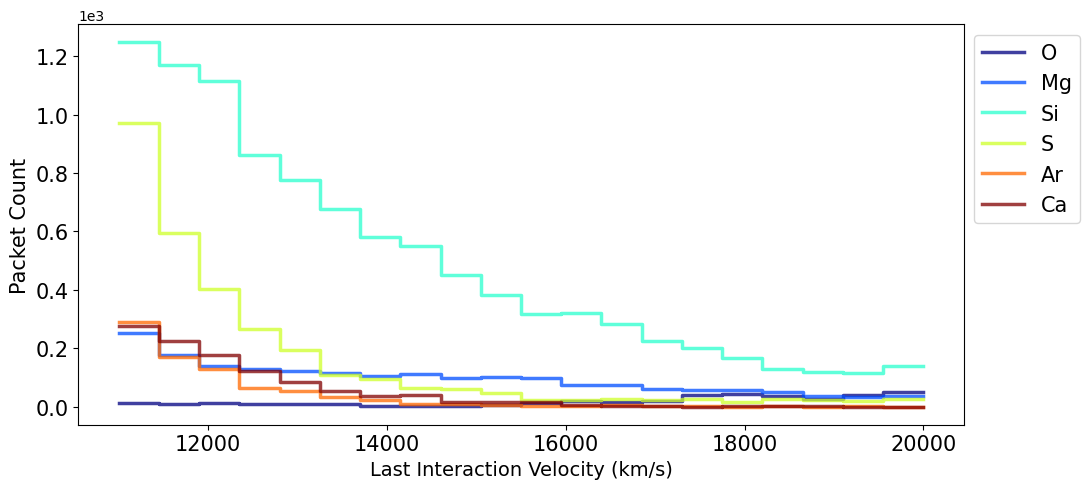

In [94]:
cmapname="jet"

bin_edges, plot_data, plot_colors, _species_name = _prepare_plot_data(
    None,
    velocity,
    None,
    cmapname,
    None,
    None,
)
ax = plt.figure(figsize=(11, 5)).add_subplot(111)

for data, color, name in zip(
    plot_data, plot_colors, _species_name
):
    hist, _ = np.histogram(data, bins=bin_edges)
    step_x = np.repeat(bin_edges, 2)[1:-1]
    step_y = np.repeat(hist, 2)
    ax.plot(
        step_x,
        step_y,
        label=name,
        color=color,
        linewidth=2.5,
        drawstyle="steps-post",
        alpha=0.75,
    )

ax.ticklabel_format(axis="y", scilimits=(0, 0))
ax.tick_params("both", labelsize=15)
ax.set_xlabel("Last Interaction Velocity (km/s)", fontsize=14)
ax.set_ylabel("Packet Count", fontsize=15)
ax.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0), loc="upper left")
ax.figure.tight_layout()



### Data Calculation

In [62]:
from tardis.util.base import (
    element_symbol2atomic_number,
    roman_to_int,
    species_string_to_tuple,
)

species_in_model = np.unique(packets_df_line_interaction["last_line_interaction_species"]
                .values
            )
species_list = [
                f"{atomic_number2element_symbol(specie // 100)}"
                for specie in species_in_model
            ]

full_species_list = []

#TODO: The "-" is not needed in this case.
for spec in species_list:
    # check if a hyphen is present. If it is, then it indicates a
    # range of ions. Add each ion in that range to the list as a new entry
    if "-" in spec:
        # split the string on spaces. First thing in the list is then the element
        element = spec.split(" ")[0]
        # Next thing is the ion range
        # convert the requested ions into numerals
        first_ion_numeral = roman_to_int(
            spec.split(" ")[-1].split("-")[0]
        )
        second_ion_numeral = roman_to_int(
            spec.split(" ")[-1].split("-")[-1]
        )
        # add each ion between the two requested into the species list
        for ion_number in np.arange(
            first_ion_numeral, second_ion_numeral + 1
        ):
            full_species_list.append(
                f"{element} {int_to_roman(ion_number)}"
            )
    else:
        # Otherwise it's either an element or ion so just add to the list
        full_species_list.append(spec)

species_mapped = {}
requested_species_ids = []
keep_colour = []
for spec_id in full_species_list:
    if " " in spec_id:
        species_id = (
            species_string_to_tuple(spec_id)[0] * 100
            + species_string_to_tuple(spec_id)[1]
        )
        requested_species_ids.append([species_id])
        species_mapped[species_id] = [species_id]
    else:
        atomic_number = element_symbol2atomic_number(spec_id)
        species_ids = [
                            atomic_number * 100 + ion_number
                            for ion_number in np.arange(atomic_number)
                        ]
        requested_species_ids.append(species_ids)
        species_mapped[atomic_number * 100] = species_ids
        keep_colour.append(atomic_number)
requested_species_ids = [
                    species_id
                    for temp_list in requested_species_ids
                    for species_id in temp_list
                ]

species_list = requested_species_ids
print(species_list, "here")
print(species_mapped, "Species mapped")


[800, 801, 802, 803, 804, 805, 806, 807, 800, 801, 802, 803, 804, 805, 806, 807, 800, 801, 802, 803, 804, 805, 806, 807, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 181

In [63]:
print(species_list, "species list")
msk = np.isin(species_list, species_in_model)
species = np.array(species_list)[msk]

species_name = []
for species_key, species_ids in species_mapped.items():
    if any(s_id in species for s_id in species_ids):
        if species_key % 100 == 0:
            label = atomic_number2element_symbol(species_key // 100)
        else:
            atomic_number = species_key // 100
            ion_number = species_key % 100
            ion_numeral = int_to_roman(ion_number + 1)
            label = f"{atomic_number2element_symbol(atomic_number)} {ion_numeral}"
        species_name.append(label)

[800, 801, 802, 803, 804, 805, 806, 807, 800, 801, 802, 803, 804, 805, 806, 807, 800, 801, 802, 803, 804, 805, 806, 807, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 181

In [64]:
cmap = plt.get_cmap("jet", len(species_name))

In [65]:
color_list = []
species_keys = list(species_mapped.keys())
num_species = len(species_keys)

for species_counter, species_key in enumerate(species_keys):
    if any(
        spe_id in species
        for spe_id in species_mapped[species_key]
    ):
        color = cmap(species_counter / num_species)
        color_list.append(color)

print(color_list)

[(0.0, 0.0, 0.5, 1.0), (0.0, 0.3, 1.0, 1.0), (0.16129032258064513, 1.0, 0.8064516129032259, 1.0), (0.806451612903226, 1.0, 0.1612903225806449, 1.0), (1.0, 0.40740740740740733, 0.0, 1.0), (0.5, 0.0, 0.0, 1.0)]


In [66]:
# Filter packets based on wavelength range (optional)
packet_wvl_range = None  # Set to None to include all packets
packet_nu_line_range_mask = np.ones(packets_df_line_interaction.shape[0], dtype=bool)

In [67]:
# Group packets by last interaction species
groups = packets_df_line_interaction.loc[packet_nu_line_range_mask].groupby(
    by="last_line_interaction_species"
)
plot_colors = []
plot_data = []
species_not_wvl_range = []
species_counter = 0

for specie_list in species_mapped.values():
    full_v_last = []
    for specie in specie_list:
        if specie in species:
            if specie not in groups.groups:
                atomic_number = specie // 100
                ion_number = specie % 100
                ion_numeral = int_to_roman(ion_number + 1)
                label = f"{atomic_number2element_symbol(atomic_number)} {ion_numeral}"
                species_not_wvl_range.append(label)
                continue
            g_df = groups.get_group(specie)
            r_last_interaction = (
                g_df["last_interaction_in_r"].values * u.cm
            )
            v_last_interaction = (
                r_last_interaction / time_explosion
            ).to("km/s")
            full_v_last.extend(v_last_interaction)
        if full_v_last:
            plot_data.append(full_v_last)
            print(species_counter, "here")
            plot_colors.append(color_list[species_counter])
            species_counter += 1

0 here
1 here
2 here
3 here
4 here
5 here
6 here


IndexError: list index out of range

In [68]:
# # Calculate last interaction velocities
# plot_data = []
# species_names = []
# for species_id, group_df in groups:
#     r_last_interaction = group_df["last_interaction_in_r"].values * u.cm
#     v_last_interaction = (r_last_interaction / time_explosion).to("km/s")
#     plot_data.append(v_last_interaction)

#     # Convert species ID to element symbol and ion number
#     atomic_number = species_id // 100
#     ion_number = species_id % 100
#     ion_numeral = int_to_roman(ion_number + 1)
#     species_name = f"{atomic_number2element_symbol(atomic_number)} {ion_numeral}"
#     species_names.append(species_name)

bin_edges = (velocity).to("km/s")

## Plotting

### Matplotlib

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(11, 5))


# Plot the data for each species
for data, color, name in zip(
            plot_data, plot_colors, species_name
        ):
            hist, _ = np.histogram(data, bins=bin_edges)
            step_x = np.repeat(bin_edges, 2)[1:-1]
            step_y = np.repeat(hist, 2)
            ax.plot(
                step_x,
                step_y,
                label=name,
                color=color,
                linewidth=2.5,
                drawstyle="steps-post",
                alpha=0.75,
            )

# Add labels and legend
ax.ticklabel_format(axis="y", scilimits=(0, 0))
ax.tick_params("both", labelsize=15)
ax.set_xlabel("Last Interaction Velocity (km/s)", fontsize=14)
ax.set_ylabel("Packet Count", fontsize=15)
ax.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0), loc="upper left")
ax.figure.tight_layout()

# Show the plot
plt.show()

### Plotly

In [ ]:
import plotly.graph_objects as go

# Create the plot
fig = go.Figure()

# Plot the data for each species
for species_data, species_name in zip(plot_data, species_names):
    hist, bin_edges = np.histogram(species_data, bins=velocity.to("km/s"))
    step_x = np.repeat(bin_edges, 2)[1:-1]
    step_y = np.repeat(hist, 2)
    fig.add_trace(
        go.Scatter(
            x=step_x,
            y=step_y,
            mode="lines",
            line=dict(shape="hv", width=2.5),
            name=species_name,
            opacity=0.75,
        )
    )

# Add labels and layout
fig.update_layout(
    height=600,
    xaxis_title="Last Interaction Velocity (km/s)",
    yaxis_title="Packet Count",
    font=dict(size=15),
    yaxis=dict(exponentformat="e"),
)

# Show the plot
fig.show()